In [5]:
#给每条染色体的pc值尾接onehot编码 将每个cell的每条染色体作为一个样本输入模型
#通过全局平均池化适应不同输入长度

import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate,GlobalMaxPooling1D)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical as labelEncoding
from keras.utils import plot_model  
 


def Simple1DCNN():
    bin_num=None
    # class_num=len(list(set(label['cell_type'])))
    class_num = 2
    model = Sequential()
    model.add(Conv1D(64,5,activation='relu',input_shape=(bin_num,1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128,3,activation='relu'))
    # model.add(MaxPooling1D(2))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(class_num, activation='softmax'))
    model.summary()
    return model

def train(model,dataset,epochs,batch_size,lr):
    Optimizer=Adam(learning_rate=lr)
    X_train_3d, y_train, X_test_3d ,y_test=dataset
    model.compile(loss='categorical_crossentropy', optimizer=Optimizer, 
                    metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss',  
                                mode='min',          
                                patience=5,          
                                verbose=1)

    model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test), callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_3d, y_test)
    print('Accuracy: %.2f%%' % (accuracy * 100))
    # model.save("test_model.h5")

    return model




We're using TF-2.14.0.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 64)          384       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         24704     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                

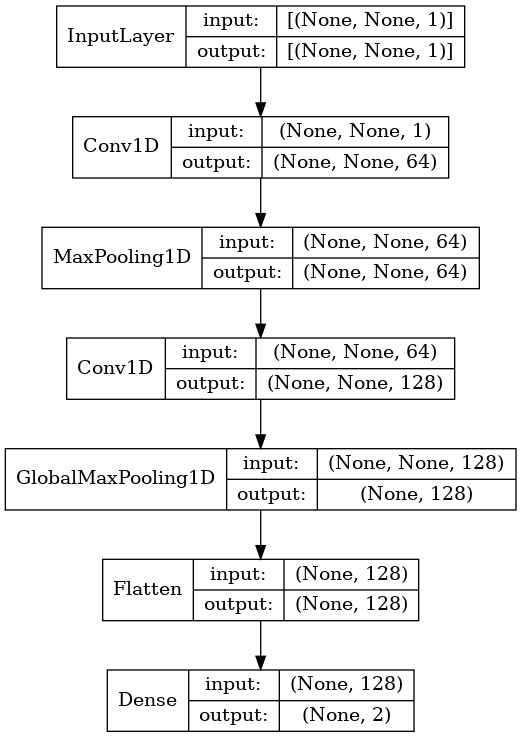

In [6]:
model = Simple1DCNN()
plot_model(model, to_file='model-chr-onehot.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [55]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


def load_sim_data(data,label,chr_index):
    data_np=np.array(data)
    label_encoder = LabelEncoder()
    indexed_labels = label_encoder.fit_transform(label)
    onehot_encoder = OneHotEncoder(sparse=False)
    encoded_labels = onehot_encoder.fit_transform(indexed_labels.reshape(-1, 1))
    encoded_labels_df = pd.DataFrame(encoded_labels, columns=[f'_{i}' for i in range(encoded_labels.shape[1])])
    X_train, X_test, y_train, y_test = train_test_split(data_np.transpose(), encoded_labels_df, test_size=0.2, random_state=123)
    X_train_3d = np.expand_dims(X_train, axis=2)
    X_test_3d = np.expand_dims(X_test, axis=2)
    # print("X_train.shape:", X_train_3d.shape)
    # print("y_train.shape:", y_train.shape)
    # print()
    # print("X_test.shape:", X_test_3d.shape)
    # print("y_test.shape:", y_test.shape)
    train_dataset =[]
    test_dataset = []
    input_shapes_list =[]
    for i in range(len(chr_index)):
    # for i in range(2):
        train_dataset.append(X_train_3d[:,chr_index[i],:])
        input_shapes_list.append(X_train_3d[:,chr_index[i],:].shape[1:])
        test_dataset.append(X_test_3d[:,chr_index[i],:])
    dataset = (train_dataset,y_train,test_dataset,y_test) 


    return dataset

In [51]:

def train_test(model,dataset,epochs,batch_size,lr,y_train,y_test):
    Optimizer=Adam(learning_rate=lr)
    X_train_3d, X_test_3d=dataset
    model.compile(loss='categorical_crossentropy', optimizer=Optimizer, 
                    metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss',  
                                mode='min',          
                                patience=5,          
                                verbose=1)

    model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test), callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_3d, y_test)
    print('Accuracy: %.2f%%' % (accuracy * 100))
    # model.save("test_model.h5")

    return model

In [56]:
dataset=load_sim_data(data,label,chr_index)


/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
X_train_3d, y_train, X_test_3d ,y_test=dataset
for X_train, X_test in zip(X_train_3d, X_test_3d):
    dataset_test =(X_train,X_test)
    train_test(model,dataset_test,12,20,0.001,y_train,y_test)
    

Epoch 1/12


94/94 [==============================] - 2s 13ms/step - loss: 0.3344 - accuracy: 0.8815 - val_loss: 0.0423 - val_accuracy: 1.0000
Epoch 2/12
94/94 [==============================] - 1s 10ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 3/12
94/94 [==============================] - 1s 10ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/12
94/94 [==============================] - 1s 10ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/12
94/94 [==============================] - 1s 10ms/step - loss: 8.9410e-04 - accuracy: 1.0000 - val_loss: 7.8180e-04 - val_accuracy: 1.0000
Epoch 6/12
94/94 [==============================] - 1s 9ms/step - loss: 5.8580e-04 - accuracy: 1.0000 - val_loss: 5.2701e-04 - val_accuracy: 1.0000
Epoch 7/12
94/94 [==============================] - 1s 9ms/step - loss: 4.1174e-04 - accuracy: 1.0000 - val_loss: 3.7919e-04 - val_accuracy: 1.0000
Ep

In [25]:
#按染色体划分数据集
import h5py
parm = 'mean4'
print(f"处理参数: {parm}")
# data1_path = '/home/sim_data/meanA-1.csv'
# data2_path = '/home/sim_data/var1.5.csv'
data1_path = '/home/dataset/sim_data/cellcycle/1m/compartment_raw_0_1171.csv_mean1+var1.csv'
data2_path = '/home/dataset/sim_data/cellcycle/1m/compartment_raw_0_1171.csv_'+parm+'.csv'

chr_list = ["chr1","chr2","chr3","chr4","chr5",
"chr6","chr7","chr8","chr9","chr10",
"chr11","chr12","chr13","chr14","chr15",
"chr16","chr17","chr18","chr19",'chrX']
X=h5py.File('/home/dataset/cellcycle/1m/tmp/scCompartment_cellcycle.hdf5', 'r')
bin_chr = np.array([chrom.decode('utf-8') for chrom in X['compartment_raw']['bin']['chrom']])
chr_index ={}
    # chr_data =[]
print(chr_list)
for i in range(len(chr_list)):
        chr_index[i] = np.where(bin_chr == chr_list[i])[0]

# print(data2_path)
# data3_path = '/home/sim_data/var1.5.csv'
# print(chr_index[19])
data1 = pd.read_csv(data1_path,index_col=0)
data2 = pd.read_csv(data2_path,index_col=0)
# data3 = pd.read_csv(data3_path,index_col=0)
a=data1.iloc[:,:-5]
b=data2.iloc[:,:-5]
# c=data3.iloc[:,:-5]
data=pd.merge(a,b,left_index=True,right_index=True)
label1=['A']*a.shape[1]
label2=['B']*a.shape[1]
# label3=['C']*a.shape[1]
label=[]
label.extend(label1)
label.extend(label2)

处理参数: mean4
['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


In [44]:
dataset=load_sim_data(data,label,chr_index)


/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(1873, 194, 1)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 194 and the array at index 1 has size 179

In [29]:
model = train(model,dataset,12,20,0.001)

Epoch 1/12


ValueError: in user code:

    File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_1" expects 1 input(s), but it received 20 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 194, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 179, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 157, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 153, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 150, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 147, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 144, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 128, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 122, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 127, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 119, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 119, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 118, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 123, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 101, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 96, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 94, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 88, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 59, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 164, 1) dtype=float32>]


In [12]:
temp_data = np.array(data).T

In [16]:
temp_data[:,chr_index[0]]

array([[-0.86967149, -0.91496574, -0.89458367, ...,  0.40375956,
         0.62312249,  0.29778883],
       [ 0.24187111,  0.20496236,  0.22362898, ...,  1.75233999,
         2.00052971,  1.57062226],
       [-1.26765332, -1.31594996, -1.29495368, ..., -0.07909239,
         0.12994926, -0.15794231],
       ...,
       [-0.41220476, -0.45404787, -0.43437181, ...,  2.30250304,
         3.19464977,  1.84000663],
       [-0.66111705, -0.70483796, -0.68477775, ...,  2.00050991,
         2.88620133,  1.55497583],
       [-1.19950877, -1.24729132, -1.22640021, ...,  1.34730549,
         2.21903423,  0.93846056]])

   feature_1  feature_2  feature_3  feature_4
0          1          2        3.0        NaN
1          4          5        6.0        NaN
2          7          8        9.0        NaN
3         10         11        NaN        NaN
4         12         13        NaN        NaN
5         14         15        NaN        NaN
6         16         17       18.0       19.0
7         20         21       22.0       23.0
8         24         25       26.0       27.0
